<a href="https://colab.research.google.com/github/AbhishekSinghRwt/Brain_Tumor_Detection/blob/main/Brain_tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BRAIN TUMOR DETECTION

**Context**

In this notebook, we investigate the task of detecting brain cancers from MRI scans using Convolutional Neural Networks (CNNs) and Pre-trained Models. Brain tumors are a major health concern worldwide, and early diagnosis is critical to treatment and patient outcomes. With advances in deep learning and medical imaging technologies, CNNs have emerged as valuable tools for automating abnormality identification in medical pictures.

**Sources and DATA From :**

https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

**Type of Machine Learning Problem :**

This study's dataset consists of MRI (Magnetic Resonance Imaging) scans of the brain obtained from patients with and without brain malignancies. This is binary Classification Problem . Each image in the collection is labeled 'yes' or 'no' to indicate the presence or absence of a tumor.

**IMPORTING LIBRARIES**

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install opendatasets

**DOWNLOADING DATASET**

In [3]:
import opendatasets as od

od.download(
    "https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abhisheksinghrawat
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection


100%|██████████| 15.1M/15.1M [00:00<00:00, 16.9MB/s]


**Loading Images:**

In [74]:
path_No = '/content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/no/*'
path_Yes = '/content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/*'

tumor = []
no_tumor = []
random_state = 42

for file in glob.iglob(path_Yes):
    img = cv2.imread(file)      #Reading the images from the path
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        #Changing the color from BGR to RGB
    img = cv2.resize(img, (224, 224))
    tumor.append((img, 1))  # Appending tuple with image and label 1 (indicating presence of tumor)

for file in glob.iglob(path_No):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    no_tumor.append((img, 0))  # Appending tuple with image and label 0 (indicating absence of tumor)

# Concatenating the two lists and shuffle the data
all_data = tumor + no_tumor


# Splitting data and labels
data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

**Image Demonstration :**

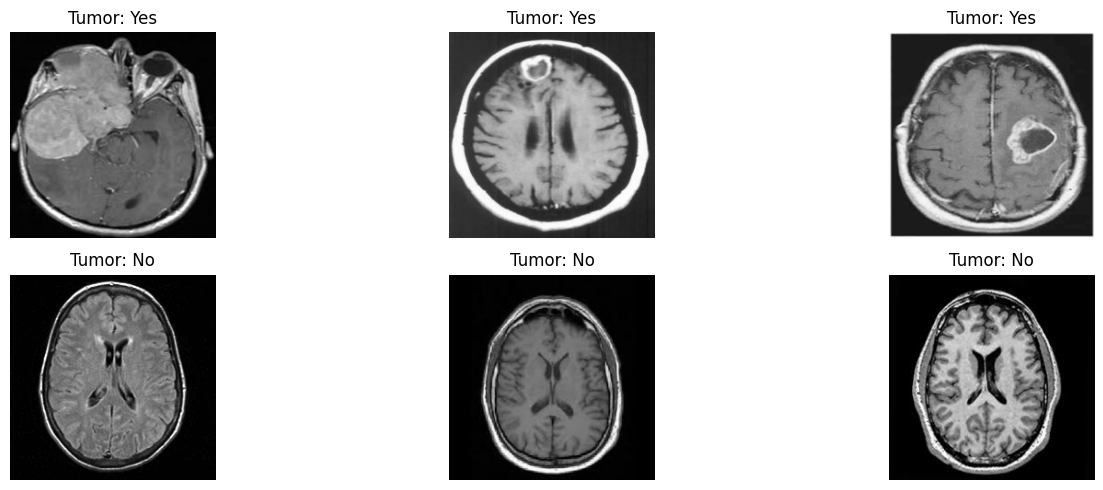

In [75]:
plt.figure(figsize=(15, 5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(tumor[i][0])
    plt.title("Tumor: Yes")
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(no_tumor[i][0])
    plt.title("Tumor: No")
    plt.axis('off')

plt.tight_layout()
plt.show()


**Distrbution of Class Lables**

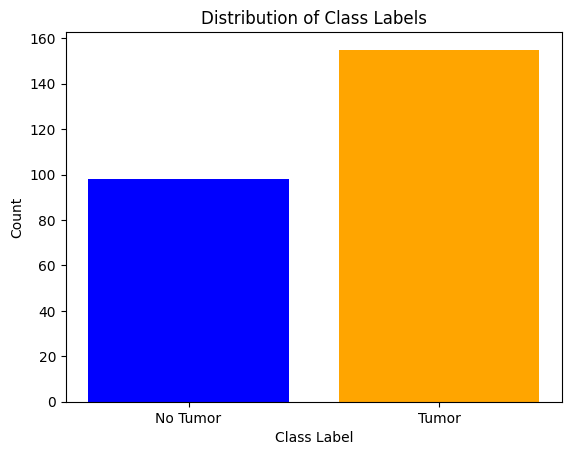

In [76]:
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

**Splitting the Dataset**

In [77]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, random_state=42)

In [78]:
# Normalize the pixel values to the range [0, 1]
x_train= x_train /255.0
x_test = x_test / 255.0

**Building BASE Model**

In [79]:
model = keras.Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding='same', input_shape=[224, 224, 3]))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(.25))
model.add(Dense(units=1, activation="sigmoid"))

In [80]:
model.compile(optimizer='Adam',loss='binary_crossentropy', metrics=['accuracy'])

In [81]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 28, 28, 128)     

In [82]:
#including early stopping to prevent overfitting
early_stopping = EarlyStopping(
                              patience=10,
                              min_delta=0.001,
                              monitor="val_loss",
                              restore_best_weights=True
                              )

In [83]:
history = model.fit(x_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=early_stopping)

Epoch 1/100
5/5 [==============================] - 2s 135ms/step - loss: 0.6340 - accuracy: 0.5603 - val_loss: 0.5242 - val_accuracy: 0.7778
Epoch 2/100
5/5 [==============================] - 0s 60ms/step - loss: 0.5188 - accuracy: 0.7660 - val_loss: 0.5789 - val_accuracy: 0.6389
Epoch 3/100
5/5 [==============================] - 0s 67ms/step - loss: 0.5169 - accuracy: 0.7872 - val_loss: 0.4837 - val_accuracy: 0.7778
Epoch 4/100
5/5 [==============================] - 0s 59ms/step - loss: 0.4786 - accuracy: 0.8085 - val_loss: 0.4654 - val_accuracy: 0.7778
Epoch 5/100
5/5 [==============================] - 0s 68ms/step - loss: 0.4377 - accuracy: 0.8014 - val_loss: 0.4586 - val_accuracy: 0.7778
Epoch 6/100
5/5 [==============================] - 0s 58ms/step - loss: 0.4183 - accuracy: 0.8227 - val_loss: 0.4333 - val_accuracy: 0.7778
Epoch 7/100
5/5 [==============================] - 0s 68ms/step - loss: 0.4262 - accuracy: 0.8156 - val_loss: 0.4153 - val_accuracy: 0.7778
Epoch 8/100
5/5 [==

**Base Model Performance**

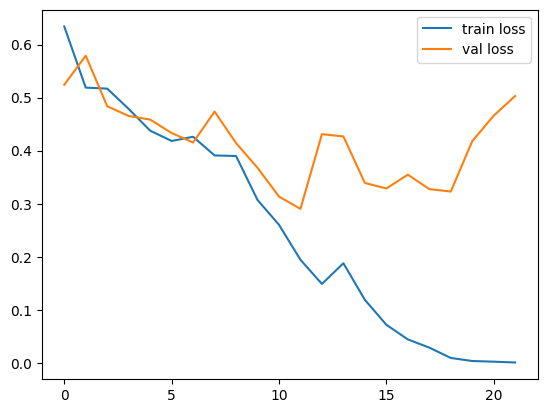

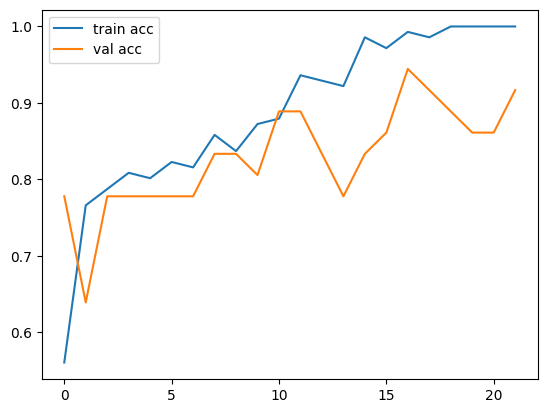

<Figure size 640x480 with 0 Axes>

In [84]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [85]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

3/3 [==============================] - 0s 22ms/step - loss: 0.6692 - accuracy: 0.8158
Test Loss: 0.6692212224006653
Test Accuracy: 0.8157894611358643


3/3 [==============================] - 0s 21ms/step
Accuracy on test Set: 0.816 %


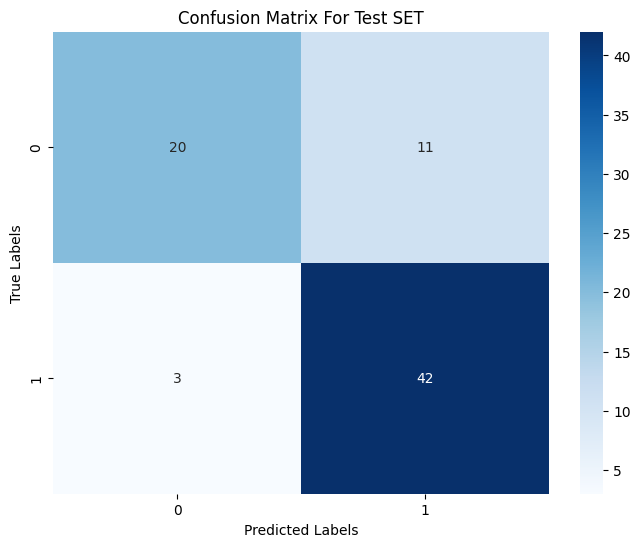

In [86]:
predictions = model.predict(x_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

conf_matrix = confusion_matrix(y_test, predictions)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy on test Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test SET')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**USING PRETRAINED VGG16 MODEL**

In [87]:
vgg16 = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

In [88]:
for layer in vgg16.layers:
   layer.trainable = False

In [89]:
model2 = keras.Sequential()
model2.add(vgg16)
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

In [90]:
model2.compile(optimizer='Adam',loss='binary_crossentropy', metrics=['accuracy'])

In [91]:
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_12 (Dropout)        (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               3211392   
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 17926209 (68.38 MB)
Trainable params: 3

In [92]:
#including early stopping to prevent overfitting
early_stopping = EarlyStopping(
                              patience=10,
                              min_delta=0.001,
                              monitor="val_loss",
                              restore_best_weights=True
                              )

In [93]:
history2 = model2.fit(x_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=early_stopping)

Epoch 1/100
5/5 [==============================] - 4s 470ms/step - loss: 2.1325 - accuracy: 0.5461 - val_loss: 1.3406 - val_accuracy: 0.3889
Epoch 2/100
5/5 [==============================] - 1s 212ms/step - loss: 1.1728 - accuracy: 0.6099 - val_loss: 0.6473 - val_accuracy: 0.6944
Epoch 3/100
5/5 [==============================] - 1s 172ms/step - loss: 0.6039 - accuracy: 0.7376 - val_loss: 0.5841 - val_accuracy: 0.6667
Epoch 4/100
5/5 [==============================] - 1s 212ms/step - loss: 0.4747 - accuracy: 0.8085 - val_loss: 0.4589 - val_accuracy: 0.7500
Epoch 5/100
5/5 [==============================] - 1s 178ms/step - loss: 0.4301 - accuracy: 0.7730 - val_loss: 0.4144 - val_accuracy: 0.7778
Epoch 6/100
5/5 [==============================] - 1s 164ms/step - loss: 0.4375 - accuracy: 0.8369 - val_loss: 0.3718 - val_accuracy: 0.8056
Epoch 7/100
5/5 [==============================] - 1s 167ms/step - loss: 0.2986 - accuracy: 0.8582 - val_loss: 0.3593 - val_accuracy: 0.8056
Epoch 8/100
5

**Pre-Trained Model Performance**

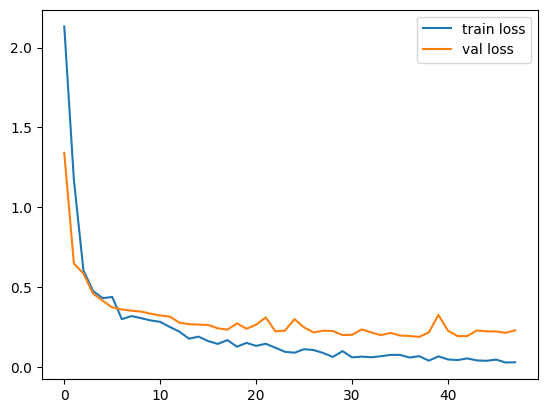

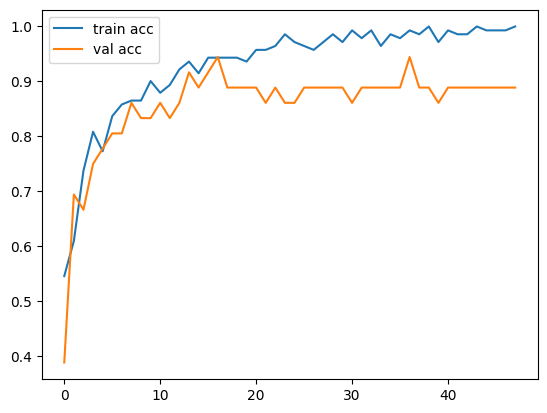

<Figure size 640x480 with 0 Axes>

In [94]:
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history2.history['accuracy'], label='train acc')
plt.plot(history2.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [95]:
test_loss, test_acc = model2.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

3/3 [==============================] - 0s 98ms/step - loss: 0.3771 - accuracy: 0.8553
Test Loss: 0.37706419825553894
Test Accuracy: 0.8552631735801697


3/3 [==============================] - 0s 123ms/step
Accuracy on Test Set: 0.855 %


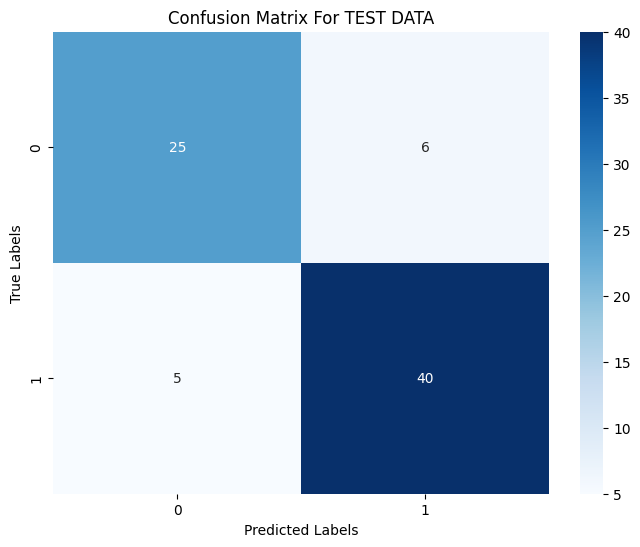

In [96]:

predictions = model2.predict(x_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

conf_matrix = confusion_matrix(y_test, predictions)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy on Test Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For TEST DATA')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [98]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Model", "Accuracy"]
x.add_row(["Base Model", 0.8157894611358643 ])
x.add_row(["Pre-Trained VGG Model",0.8552631735801697])
print(x)

+-----------------------+--------------------+
|         Model         |      Accuracy      |
+-----------------------+--------------------+
|       Base Model      | 0.8157894611358643 |
| Pre-Trained VGG Model | 0.8552631735801697 |
+-----------------------+--------------------+
